In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

# Upload kaggle.json
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

dataset = 'tawsifurrahman/covid19-radiography-database'
path = 'covid19-radiography-database'
api.dataset_download_files(dataset, path=path, unzip=True)

import os
from sklearn.model_selection import train_test_split
import shutil

def create_dataset_folders(base_path):
    dataset_path = os.path.join(base_path, 'COVID-19_Radiography_Dataset')
    classes = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
    for cls in classes:
        class_path = os.path.join(dataset_path, cls, 'images')
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.png')]
        train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
        for img_set, folder in zip([train_imgs, test_imgs], ['train', 'test']):
            folder_path = os.path.join(base_path, folder, cls)
            os.makedirs(folder_path, exist_ok=True)
            for img in img_set:
                shutil.copy(img, folder_path)

create_dataset_folders(path)


Mounted at /content/drive


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.utils import class_weight
import numpy as np
import re

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4
save_dir = '/content/drive/MyDrive/COVID19_Image_Classification'
os.makedirs(save_dir, exist_ok=True)

train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = test_gen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

labels = train_generator.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))


Found 16930 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


In [5]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-9, 1. - 1e-9)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss


class SaveToDriveCallback(Callback):
    def __init__(self, path):
        super().__init__()
        self.path = path
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        fname = f'model_epoch_{epoch+1:02d}_val_loss_{val_loss:.2f}.keras'
        self.model.save(os.path.join(self.path, fname))
        print(f"✅ Saved model to {fname}")


In [6]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False  # freeze base model

model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[SaveToDriveCallback(save_dir)]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


KeyboardInterrupt: 

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

model_files = [f for f in os.listdir(save_dir) if f.endswith('.keras')]
latest = sorted(model_files)[-1]
model = load_model(os.path.join(save_dir, latest), custom_objects={'loss': focal_loss()})

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


  8/133 ━━━━━━━━━━━━━━━━━━━━ 2:52 1s/step

KeyboardInterrupt: 

In [8]:
# Unfreeze top 30 layers of MobileNetV2 for fine-tuning
for layer in model.layers[-30:]:
    layer.trainable = True

# Compile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=focal_loss(), metrics=['accuracy'])

# Continue training for 10 more epochs
model.fit(
    train_generator,
    validation_data=test_generator,
    initial_epoch=20,
    epochs=30,
    class_weight=class_weights,
    callbacks=[SaveToDriveCallback(save_dir)]
)


Epoch 21/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5260 - loss: 0.2167✅ Saved model to model_epoch_21_val_loss_0.07.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 1295s 2s/step - accuracy: 0.5261 - loss: 0.2165 - val_accuracy: 0.7736 - val_loss: 0.0710
Epoch 22/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6665 - loss: 0.1009✅ Saved model to model_epoch_22_val_loss_0.06.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 1257s 2s/step - accuracy: 0.6665 - loss: 0.1008 - val_accuracy: 0.7948 - val_loss: 0.0644
Epoch 23/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6989 - loss: 0.0805✅ Saved model to model_epoch_23_val_loss_0.06.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 1272s 2s/step - accuracy: 0.6989 - loss: 0.0805 - val_accuracy: 0.7983 - val_loss: 0.0598
Epoch 24/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7262 - loss: 0.0644✅ Saved model to model_epoch_24_val_loss_0.06.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 1274s 2s/step - accuracy: 0.7262 - loss: 0.0644 - val_accuracy: 0.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

log_path = os.path.join(save_dir, 'training_log.csv')  # if you used CSVLogger before
history_df = pd.read_csv(log_path)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Acc')
plt.plot(history_df['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/COVID19_Image_Classification/training_log.csv'

In [9]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name="Conv_1"):
    img_array = get_img_array(img_path, size=(224, 224))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


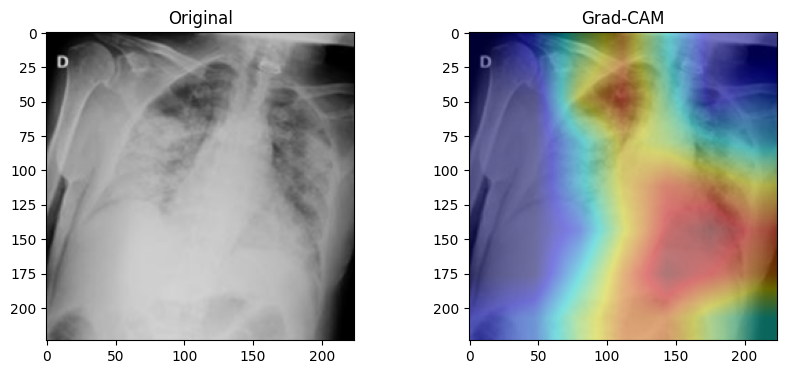

In [12]:
display_gradcam('/content/covid19-radiography-database/test/COVID/COVID-272.png', model)


In [11]:
import os

# List a few sample COVID images
covid_test_dir = '/content/covid19-radiography-database/test/COVID'
sample_images = os.listdir(covid_test_dir)
print(sample_images[:5])  # print first 5 filenames


['COVID-272.png', 'COVID-633.png', 'COVID-2085.png', 'COVID-2221.png', 'COVID-797.png']


In [13]:
# old_model = load_model('/path/to/your/old/model.keras')
# new_model = load_model('/path/to/mobilenetv2_best_model.keras', custom_objects={'loss': focal_loss()})

# def ensemble_predict(img_batch):
#     pred1 = old_model.predict(img_batch)
#     pred2 = new_model.predict(img_batch)
#     return (pred1 + pred2) / 2

# # For evaluating on test set:
# ensemble_preds = ensemble_predict(test_generator)
# y_pred = np.argmax(ensemble_preds, axis=1)
# print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))


ValueError: File not found: filepath=/path/to/your/old/model.keras. Please ensure the file is an accessible `.keras` zip file.